In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Generate text
-  prepare that for generating new text
-  tokenize the data and then create sub-sentence engrams that were labelled with the next word in the sentence. 
- one-hot encoded the labels to get us into a position where we can build a neural network that can, given a sentence, predict the next word.


In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [2]:
tokenizer = Tokenizer()
#1개의 Irish Music
data="In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."
#Tokenize 
corpus = data.lower().split("\n") #split &lower case

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words) #total number of unique 263words

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [3]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1] #list of tokens
		input_sequences.append(n_gram_sequence) # ngram으로 나누어짐


max_sequence_len = max([len(x) for x in input_sequences]) #전체 seq 가장 긴거 찾음
# pre-paddding sequences 
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label: 마지막 글자 label 나머지는 input
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
#one-hot encoding
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) 

In [4]:
print(xs, ys) #label 70 -> 70개의 열을 갖는 one-hot encoding

[[  0   0   0 ...   0   0   4]
 [  0   0   0 ...   0   4   2]
 [  0   0   0 ...   4   2  66]
 ...
 [  0   0   0 ...  61  60 262]
 [  0   0   0 ...  60 262  13]
 [  0   0   0 ... 262  13   9]] [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
#token 확인[4,2,66,8,67,68,69,70]
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

4
2
66
8
67
68
69
70


In [6]:
#training data 
print(xs[6])  # in the town of a Athy One Jeremy

[ 0  0  0  4  2 66  8 67 68 69]


In [7]:
print(ys[6])  #레이블: one-hot encoding 70th elements에 1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print(xs[5])
print(ys[5])

[ 0  0  0  0  4  2 66  8 67 68]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
print(tokenizer.word_index)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [10]:
  model = Sequential()
  model.add(Embedding(total_words, 64, input_length=max_sequence_len-1)) #label 때문에 1 제거 
  model.add(Bidirectional(LSTM(20)))
  model.add(Dense(total_words, activation='softmax')) #263

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history = model.fit(xs, ys, epochs=500, verbose=1)


Epoch 1/500
15/15 [==============================] - 0s 8ms/step - loss: 5.5691 - accuracy: 0.0022
Epoch 2/500
15/15 [==============================] - 0s 6ms/step - loss: 5.5416 - accuracy: 0.0530
Epoch 3/500
15/15 [==============================] - 0s 7ms/step - loss: 5.4775 - accuracy: 0.0508
Epoch 4/500
15/15 [==============================] - 0s 7ms/step - loss: 5.2991 - accuracy: 0.0508
Epoch 5/500
15/15 [==============================] - 0s 6ms/step - loss: 5.1277 - accuracy: 0.0508
Epoch 6/500
15/15 [==============================] - 0s 7ms/step - loss: 5.0656 - accuracy: 0.0508
Epoch 7/500
15/15 [==============================] - 0s 7ms/step - loss: 5.0255 - accuracy: 0.0530
Epoch 8/500
15/15 [==============================] - 0s 6ms/step - loss: 4.9977 - accuracy: 0.0508
Epoch 9/500
15/15 [==============================] - 0s 7ms/step - loss: 4.9722 - accuracy: 0.0508
Epoch 10/500
15/15 [==============================] - 0s 7ms/step - loss: 4.9413 - accuracy: 0.0530
Epoch 11/

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

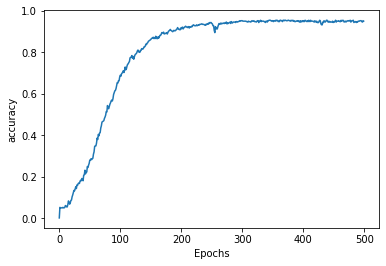

In [12]:
#200부터 0.8에서 급격하게 가까워짐
plot_graphs(history, 'accuracy')


In [13]:
#prediction of next 100 words: 입력값이 작아서 처음에는 그럴싸하다가 점점 확률이 낮아지면서 이상하게 반복도 많아지면서 생성됨
seed_text = "Laurence went to dublin"
next_words = 100  
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Laurence went to dublin merry as bees round a cask cask cask too as cask glisten glisten glisten girls were didnt eyes glisten relations ground ground ball ball hearty twas polkas eyes didnt glisten glisten glisten ladies girls out in out squeezed rose again by murther murther hoops didnt the fall wall wall ball hearty didnt polkas eyes ball glisten entangled entangled round glisten glisten glisten glisten girls out were steps me glisten ground ground ground entangled entangled me eyes glisten girls squeezed a mchugh eyes glisten girls were girls in ground harp hoops glisten glisten entangled entangled round glisten glisten glisten glisten ground


In [18]:
next_words = 10  
  
for _ in range(next_words):
  #[OOV,134,13,59]
  token_list = tokenizer.texts_to_sequences([seed_text])[0] 
  #[0,0,0,0,0,0,0 ,134,13,59]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
 
  #seq 다음 토큰값 예측
  predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""

  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

Laurence went to dublin merry as bees round a cask cask cask too as cask glisten glisten glisten girls were didnt eyes glisten relations ground ground ball ball hearty twas polkas eyes didnt glisten glisten glisten ladies girls out in out squeezed rose again by murther murther hoops didnt the fall wall wall ball hearty didnt polkas eyes ball glisten entangled entangled round glisten glisten glisten glisten girls out were steps me glisten ground ground ground entangled entangled me eyes glisten girls squeezed a mchugh eyes glisten girls were girls in ground harp hoops glisten glisten entangled entangled round glisten glisten glisten glisten ground a rose eyes glisten twas call call eyes dublin all


1692개의 문장이 있는 여러개의 노래
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt

In [19]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

data = open('/tmp/irish-lyrics-eof.txt').read()
#이전에는 하드코딩(직접 적은거 string으로 넣음)대신에 다운로드

--2020-10-03 08:17:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-10-03 08:17:41 (123 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [21]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)


{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [22]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [27]:
#token 바뀜  [ 8,1,71,6,713,38,1790,1791]
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

8
1
71
6
713
39
1790
1791


In [26]:
xs[6],ys[6]  #padding도 길어짐

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [23]:
print(tokenizer.word_index)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [28]:
#larger corpus bigger nodes
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)


Epoch 1/100
377/377 [==============================] - 4s 11ms/step - loss: 6.6378 - accuracy: 0.0735
Epoch 2/100
377/377 [==============================] - 4s 10ms/step - loss: 5.7759 - accuracy: 0.1133
Epoch 3/100
377/377 [==============================] - 4s 10ms/step - loss: 4.8507 - accuracy: 0.1671
Epoch 4/100
377/377 [==============================] - 4s 11ms/step - loss: 3.9225 - accuracy: 0.2448
Epoch 5/100
377/377 [==============================] - 4s 10ms/step - loss: 3.0786 - accuracy: 0.3530
Epoch 6/100
377/377 [==============================] - 4s 10ms/step - loss: 2.4022 - accuracy: 0.4610
Epoch 7/100
377/377 [==============================] - 4s 10ms/step - loss: 1.9271 - accuracy: 0.5508
Epoch 8/100
377/377 [==============================] - 4s 10ms/step - loss: 1.5796 - accuracy: 0.6315
Epoch 9/100
377/377 [==============================] - 4s 10ms/step - loss: 1.3494 - accuracy: 0.6798
Epoch 10/100
377/377 [==============================] - 4s 10ms/step - loss: 1.177

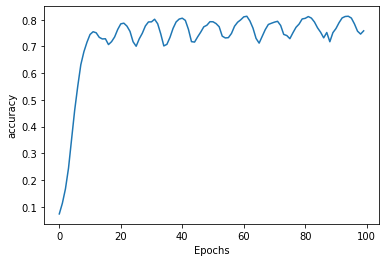

In [29]:
plot_graphs(history, 'accuracy')


In [30]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

I've got a bad feeling about this white feet was chanting done at know my bride love love love love love love love love love love love love my love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love


[generating text using a character-based RNN ](https://www.tensorflow.org/tutorials/text/text_generation)
- **character(문자)기반** RNN으로 text 생성
> 참고:Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks.] (http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

- will likely hit memory errors, as assigning the one-hot encodings of the labels to matrices that have over 31,477 elements, which is the number of unique words in the collection, and there are over 15 million sequences generated using the algorithm that we showed here. So the labels alone would require the storage of many terabytes of RAM.

-  The full number of unique characters in a corpus is far less than the full number of unique words, at least in English. So the same principles that you use to predict words can be used to apply here. The workbook is at this URL, so try it out, and once you've done, that you'll be ready for this week's final exercise.

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow.keras.utils as ku 
from tensorflow.keras import regularizers

In [37]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

--2020-10-03 08:35:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-10-03 08:35:46 (112 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [43]:
print ('텍스트의 길이: {}자'.format(len(data)))
print(data[:250]) #첫 250자


텍스트의 길이: 93578자
FROM fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou, contracted to thine own bright eyes,
Feed'st thy light'st flame with self


In [45]:
# 파일의 고유 문자수를 출력합니다.
vocab = sorted(set(data))
print ('고유 문자수 {}개'.format(len(vocab)))

고유 문자수 60개


In [ ]:
#텍스트 처리
# 토큰화 문자 수치화 -> lookup table로 문자 숫자 매핑
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1  #3211

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [53]:
tokenizer.word_index.items()

dict_items([('and', 1), ('the', 2), ('to', 3), ('of', 4), ('my', 5), ('i', 6), ('in', 7), ('that', 8), ('thy', 9), ('thou', 10), ('with', 11), ('for', 12), ('is', 13), ('love', 14), ('not', 15), ('but', 16), ('a', 17), ('me', 18), ('thee', 19), ('so', 20), ('be', 21), ('as', 22), ('all', 23), ('you', 24), ('his', 25), ('which', 26), ('when', 27), ('it', 28), ('this', 29), ('by', 30), ('your', 31), ('doth', 32), ('do', 33), ('from', 34), ('on', 35), ('or', 36), ('no', 37), ('then', 38), ('have', 39), ('what', 40), ('are', 41), ('if', 42), ('more', 43), ('mine', 44), ('their', 45), ('shall', 46), ('sweet', 47), ('time', 48), ('will', 49), ('they', 50), ('beauty', 51), ('nor', 52), ('eyes', 53), ('art', 54), ('her', 55), ('heart', 56), ('yet', 57), ('o', 58), ('than', 59), ('can', 60), ('should', 61), ('thine', 62), ('now', 63), ('where', 64), ('make', 65), ('one', 66), ('hath', 67), ('he', 68), ('fair', 69), ('still', 70), ('how', 71), ('eye', 72), ('him', 73), ('like', 74), ('true', 75)

In [38]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [39]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 6s 13ms/step - loss: 6.9071 - accuracy: 0.0210
Epoch 2/100
484/484 [==============================] - 6s 13ms/step - loss: 6.4963 - accuracy: 0.0232
Epoch 3/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3857 - accuracy: 0.0265
Epoch 4/100
484/484 [==============================] - 6s 13ms/step - loss: 6.2664 - accuracy: 0.0298
Epoch 5/100
484/484 [==============================] - 6s 13ms/step - loss: 6.1721 - accuracy: 0.0360
Epoch 6/100
484/484 [==============================] - 6s 13ms/step - loss: 6.0930 - accuracy: 0.0376
Epoch 7/100
484/484 [==============================] - 6s 12ms/step - loss: 6.0187 - accuracy: 0.0400
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 5.9390 - accuracy: 0.0464
Epoch 9/100
484/484 [==============================] - 6s 13ms/step - loss: 5.8407 - accuracy: 0.0521
Epoch 10/100
484/484 [==============================] - 6s 12ms/step - loss: 5.726

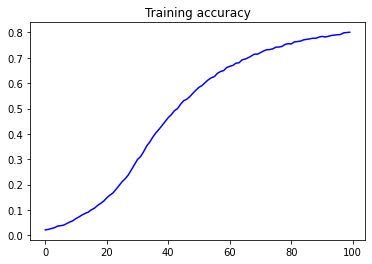

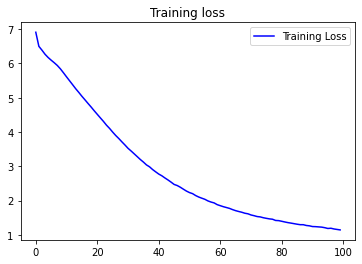

In [40]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [41]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope no air hours name afloat year thou ride cross'd still such bright away away true women's commits commits deceive wind young days did growest play of store another light amiss light borne dearer days affords strong doom delight summers' way pride find these words we seen quite earthly rhyme knife rhyme pleasure long prove men light ill heir sight out ' disdain ' did find sits given but speechless song cross laws sinful near broken decay hence disdain pleasure heaven decays decays hits torn gladly torn express'd express'd express'd rage leaves qualify quality cold pleasure new pride pleasure they prove
